# **Analysis of Factors for Predicting Diabetes in Adult Populations**
### **By: Gabriel Diaz de Leon**

#### Rationale
In the United States, diabetes is prevalent in more than 10% of the population across all ages, while more than 20% of afflicted adults are unaware of their diagnosis. This means that the ability of a large portion of adults to gauge their own risk factors is poor, which could be improved by identifying which factors can be used as secondary indicators for adults to seek medical attention. Further, understanding the relationship between self-report measures and diagnostic outcomes can inform and improve doctors’ interactions with future patients. Earlier detection of diabetes is highly correlated with reduced medical costs, suggesting that improved diagnostic practices could alleviate a significant amount of burden on the healthcare system.  
**diabetes, data analysis, machine Learning/AI, optimization, improving self-diagnostics**

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.simplefilter(action='ignore')

## Import datasets

There are two datasets to take into consideration, the binary version where patients are classified as with or without the diabetic diagnosis, and the 3-target version where patients are also classified as prediabetic. Initial visualization and correlation studies will select a single dataset for further focus.

In [2]:
bin_df = pd.read_csv('diabetes/diabetes_binary_health_indicators_BRFSS2015.csv')
tri_df = pd.read_csv('diabetes/diabetes_012_health_indicators_BRFSS2015.csv')

bin_df.rename({'Diabetes_binary': 'y'}, axis = 1, inplace=True)
tri_df.rename({'Diabetes_012': 'y'}, axis = 1, inplace=True)

bin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   y                     253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [3]:
bin_df.drop_duplicates(inplace = True)
tri_df.drop_duplicates(inplace = True)

## Cursory Analysis of Factors

In [4]:
# Using plotly.express to scan factors using distributions, identify factors with unbalanced classes
px.histogram(bin_df['DiffWalk'])

**Factors with unbalanced classes**
- CholCheck
- Stroke
- HeartDiseaseorAttack
- PhysActivity
- Veggies
- HvyAlcoholConsump
- AnyHealthcare
- NoDocbcCost
- MentHlth
- PhysHlth
- DiffWalk
- Education
- Income


## Data Visualizations
Here we will begin by visualizing the different factors as distributions based on semantic groupings

[Text(0.5, 0, 'Heavy Alcohol Consumption')]

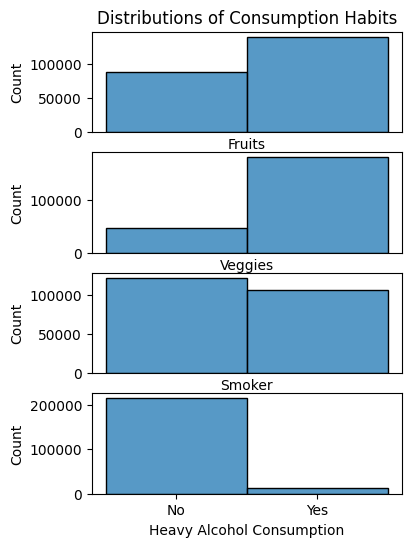

In [5]:
## Figure for distributions of variables related to consumption
# Prepare a separate data frame for generating a subplot figure
bin_consump = bin_df[['Fruits', 'Veggies', 'Smoker', 'HvyAlcoholConsump']].replace({0: 'No', 1: 'Yes'}).copy()
bin_consump['Fruits'] = pd.Categorical(bin_consump['Fruits'], ['No', 'Yes'])
bin_consump['Veggies'] = pd.Categorical(bin_consump['Veggies'], ['No', 'Yes'])
bin_consump['Smoker'] = pd.Categorical(bin_consump['Smoker'], ['No', 'Yes'])
bin_consump['HvyAlcoholConsump'] = pd.Categorical(bin_consump['HvyAlcoholConsump'], ['No', 'Yes'])

# Generate subplot figure
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(4,6))
sns.histplot(data = bin_consump, x = 'Fruits', ax = axes[0])
sns.histplot(data = bin_consump, x = 'Veggies', ax = axes[1])
sns.histplot(data = bin_consump, x = 'Smoker', ax = axes[2])
sns.histplot(data = bin_consump, x = 'HvyAlcoholConsump', ax = axes[3])
axes[0].set(xlabel='Fruits', xticklabels = [], xticks = [], title = 'Distributions of Consumption Habits')
axes[1].set(xlabel='Veggies', xticklabels = [], xticks = [])
axes[2].set(xlabel='Smoker', xticklabels = [], xticks = [])
axes[3].set(xlabel='Heavy Alcohol Consumption')

[Text(0.5, 0, 'HighChol')]

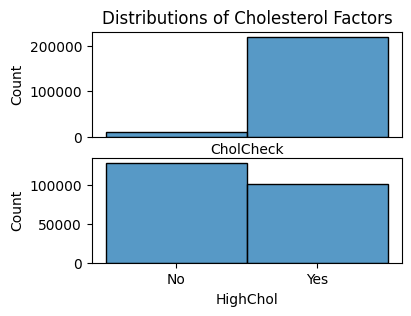

In [6]:
## Figure for distributions of variables related to cholesterol
# Prepare a separate data frame for generating a subplot figure
bin_chol = bin_df[['CholCheck', 'HighChol']].replace({0: 'No', 1: 'Yes'}).copy()
bin_chol['CholCheck'] = pd.Categorical(bin_chol['CholCheck'], ['No', 'Yes'])
bin_chol['HighChol'] = pd.Categorical(bin_chol['HighChol'], ['No', 'Yes'])

# Generate subplot figure
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(4,3))
sns.histplot(data = bin_chol, x = 'CholCheck', ax = axes[0])
sns.histplot(data = bin_chol, x = 'HighChol', ax = axes[1])
axes[0].set(xlabel='CholCheck', xticklabels = [], xticks = [], title = 'Distributions of Cholesterol Factors')
axes[1].set(xlabel='HighChol')

[Text(0.5, 0, 'PhysActivity')]

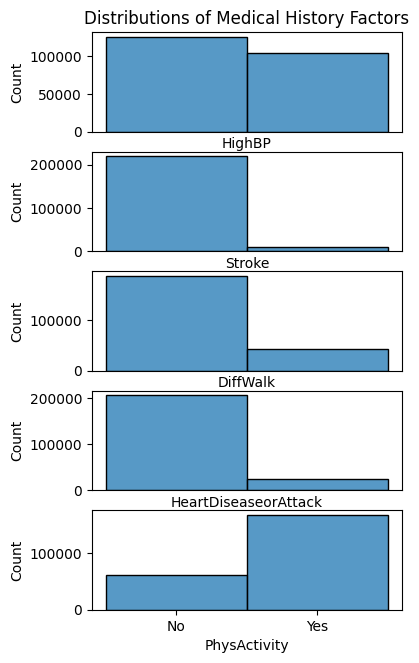

In [7]:
## Figure for distributions of variables related to medical history
# Prepare a separate data frame for generating a subplot figure
bin_history = bin_df[['HighBP', 'Stroke', 'DiffWalk', 'HeartDiseaseorAttack', 'PhysActivity']].replace({0: 'No', 1: 'Yes'}).copy()
bin_history['HighBP'] = pd.Categorical(bin_history['HighBP'], ['No', 'Yes'])
bin_history['Stroke'] = pd.Categorical(bin_history['Stroke'], ['No', 'Yes'])
bin_history['DiffWalk'] = pd.Categorical(bin_history['DiffWalk'], ['No', 'Yes'])
bin_history['HeartDiseaseorAttack'] = pd.Categorical(bin_history['HeartDiseaseorAttack'], ['No', 'Yes'])
bin_history['PhysActivity'] = pd.Categorical(bin_history['PhysActivity'], ['No', 'Yes'])

# Generate subplot figure
fig, axes = plt.subplots(ncols=1, nrows=5, figsize=(4, 7.5))
sns.histplot(data = bin_history, x = 'HighBP', ax = axes[0])
sns.histplot(data = bin_history, x = 'Stroke', ax = axes[1])
sns.histplot(data = bin_history, x = 'DiffWalk', ax = axes[2])
sns.histplot(data = bin_history, x = 'HeartDiseaseorAttack', ax = axes[3])
sns.histplot(data = bin_history, x = 'PhysActivity', ax = axes[4])
axes[0].set(xlabel='HighBP', xticklabels = [], xticks = [], title = 'Distributions of Medical History Factors')
axes[1].set(xlabel='Stroke', xticklabels = [], xticks = [])
axes[2].set(xlabel='DiffWalk', xticklabels = [], xticks = [])
axes[3].set(xlabel='HeartDiseaseorAttack', xticklabels = [], xticks = [])
axes[4].set(xlabel='PhysActivity')

[Text(0.5, 0, 'NoDocbcCost')]

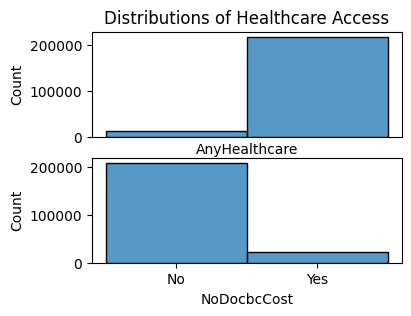

In [8]:
## Figure for distributions of variables related to healthcare access
# Prepare a separate data frame for generating a subplot figure
bin_health = bin_df[['AnyHealthcare', 'NoDocbcCost']].replace({0: 'No', 1: 'Yes'}).copy()
bin_health.head(10)
bin_health['AnyHealthcare'] = pd.Categorical(bin_health['AnyHealthcare'], ['No', 'Yes'])
bin_health['NoDocbcCost'] = pd.Categorical(bin_health['NoDocbcCost'], ['No', 'Yes'])

# Generate subplot figure
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(4,3))
sns.histplot(data = bin_health, x = 'AnyHealthcare', ax = axes[0])
sns.histplot(data = bin_health, x = 'NoDocbcCost', ax = axes[1])
axes[0].set(xlabel='AnyHealthcare', xticklabels = [], xticks = [], title = 'Distributions of Healthcare Access')
axes[1].set(xlabel='NoDocbcCost')

[Text(0.5, 0, 'BMI')]

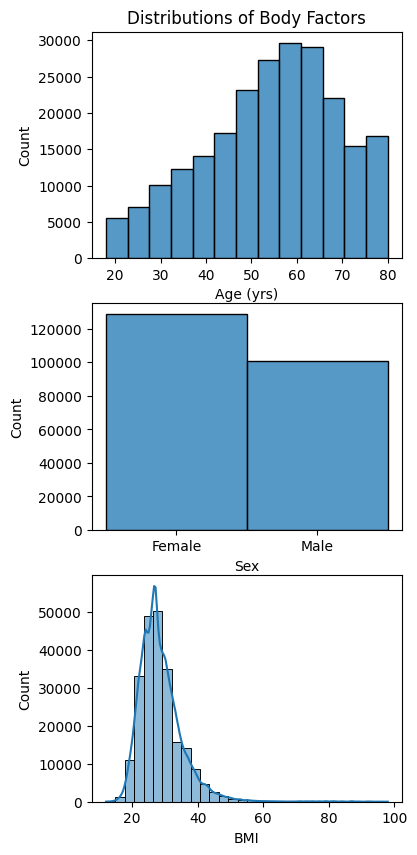

In [9]:
## Figure for distributions of variables related to body factors
# Prepare the separate data frame for generating the subplot figure
bin_body = bin_df[['Age', 'Sex', 'BMI']].copy()
bin_body['Age'].replace({1: 18, 2: 25, 3: 30, 4: 35, 5: 40, 6: 45, 7: 50, 
                         8: 55, 9: 60, 10: 65, 11: 70, 12: 75, 13: 80}, inplace = True)
bin_body['Sex'].replace({0: 'Female', 1: 'Male'}, inplace = True)

# Generate subplot figure
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(4,10))
sns.histplot(data = bin_body, x = 'Age', bins = 13, ax = axes[0])
sns.histplot(data = bin_body, x = 'Sex', bins = 2, ax = axes[1])
sns.histplot(data = bin_body, x = 'BMI', bins = 30, ax = axes[2], kde = True)
axes[0].set(xlabel='Age (yrs)', title = 'Distributions of Body Factors')
axes[1].set(xlabel='Sex')
axes[2].set(xlabel='BMI')

[[<matplotlib.axis.XTick at 0x141578550>,
 Text(0.5, 0, 'General Health Evaluation'),
 Text(0.5, 1.0, 'Distributions of Health Measures')]

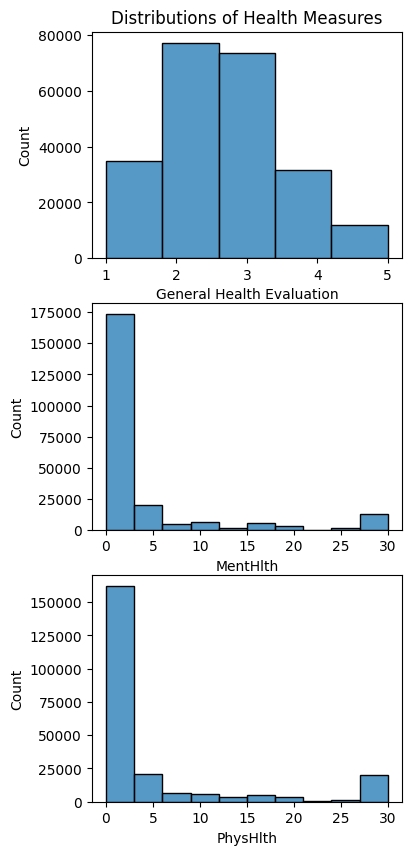

In [10]:
## Figure for distributions of variables of health measures
# Generate subplot figure
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(4,10))
sns.histplot(data = bin_df, x = 'GenHlth', bins = 5, ax = axes[0])
sns.histplot(data = bin_df, x = 'MentHlth', bins = 10, ax = axes[1])
sns.histplot(data = bin_df, x = 'PhysHlth', bins = 10, ax = axes[2])
axes[0].set(xticks = [1, 2, 3, 4, 5], xlabel = 'General Health Evaluation', title = 'Distributions of Health Measures')

[Text(0.5, 0, 'Education (Yrs spent studying)'),
 Text(0.5, 1.0, 'Distribution of Socio-Economic Factors')]

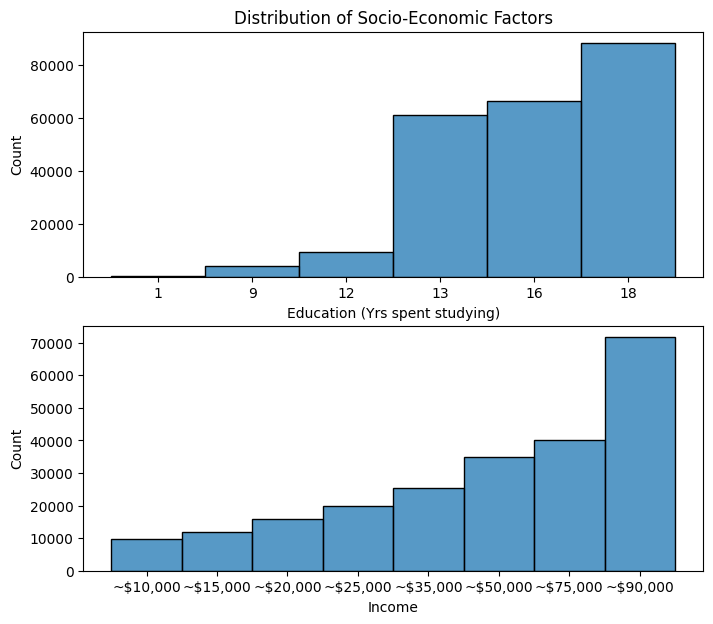

In [11]:
## Figure for distributions of variables related to socioeconomic factors
# Prepare the separate data frame for generating the subplot figure
bin_socec = bin_df[['Education', 'Income']]
bin_socec['Education'].replace({1: '1', 2: '9', 3: '12', 4: '13', 5: '16', 6: '18'}, inplace = True)
bin_socec['Education'] = pd.Categorical(bin_socec['Education'], ['1','9','12','13','16','18'])
bin_socec['Income'].replace({1: '~$10,000', 2: '~$15,000', 3: '~$20,000', 4: '~$25,000', 5: '~$35,000', 6: '~$50,000', 7: '~$75,000', 8: '~$90,000'}, inplace = True)
bin_socec['Income'] = pd.Categorical(bin_socec['Income'], ['~$10,000','~$15,000','~$20,000','~$25,000','~$35,000','~$50,000','~$75,000','~$90,000'])

# Generate subplot figure
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8,7))
sns.histplot(data = bin_socec, x = 'Education', ax = axes[0])
sns.histplot(data = bin_socec, x = 'Income', ax = axes[1])
axes[0].set(xlabel = 'Education (Yrs spent studying)', title = 'Distribution of Socio-Economic Factors')

Although several features have poorly balanced classes, their inclusion will be assessed analytically in the model testing phase.

## Compare datasets
Need to determine whether both should be analyzed or if we should focus on one in particular

Text(0.5, 1.0, 'Correlation Matrix: Binary Classification Targets')

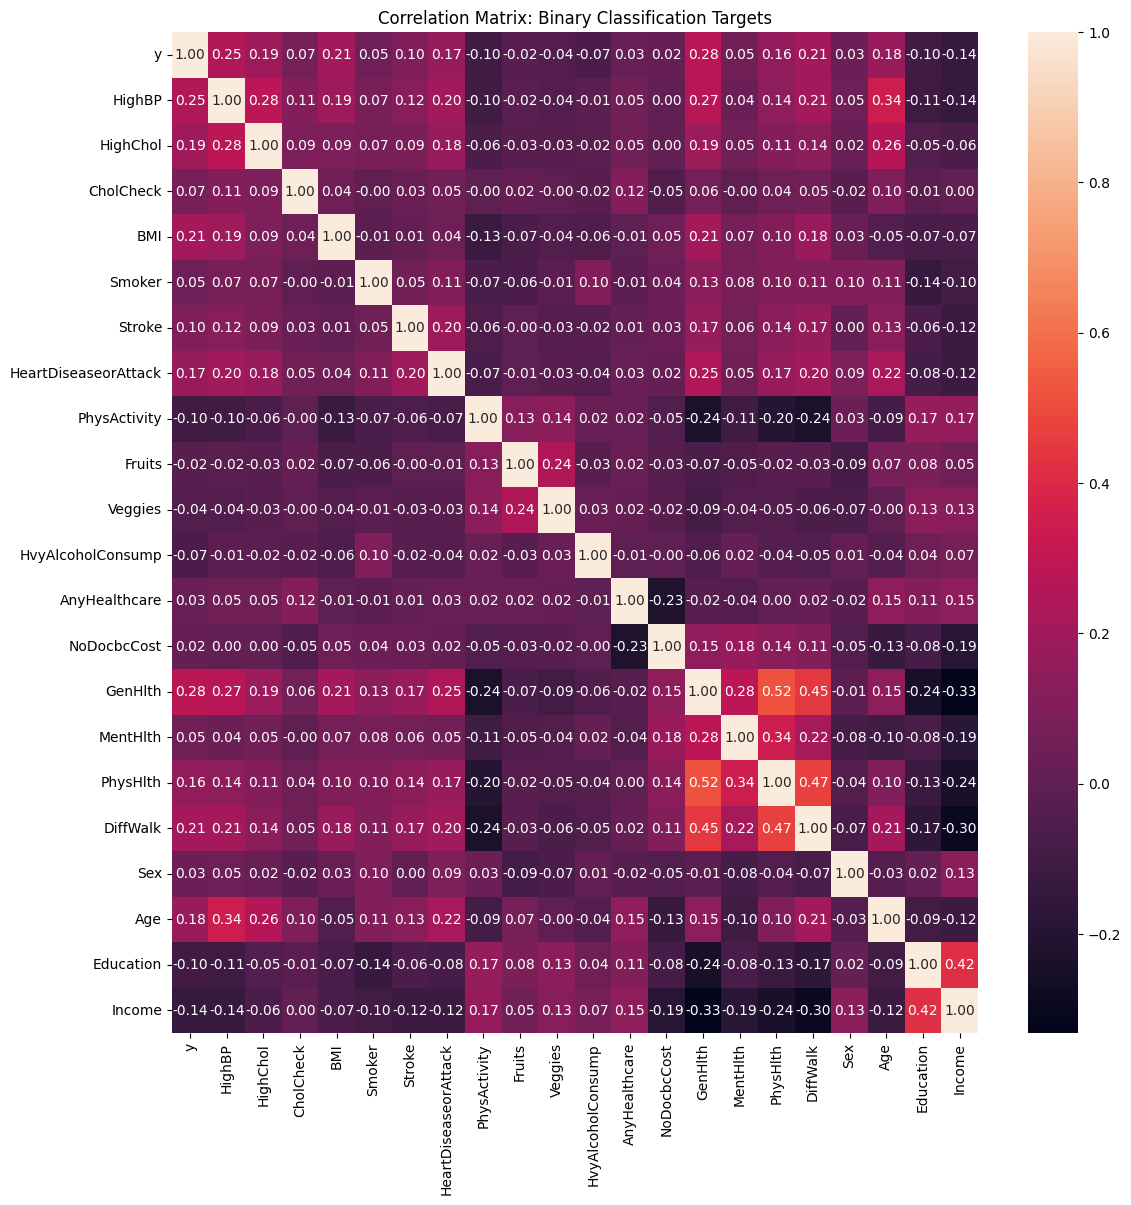

In [12]:
# Correlation matrix for 2-classification targets (healthy, diabetic)
plt.figure(figsize = (13, 13))
sns.heatmap(bin_df.corr(), annot = True, fmt = '.2f')
plt.title('Correlation Matrix: Binary Classification Targets')

Text(0.5, 1.0, 'Correlation Matrix: 3-Classification Targets')

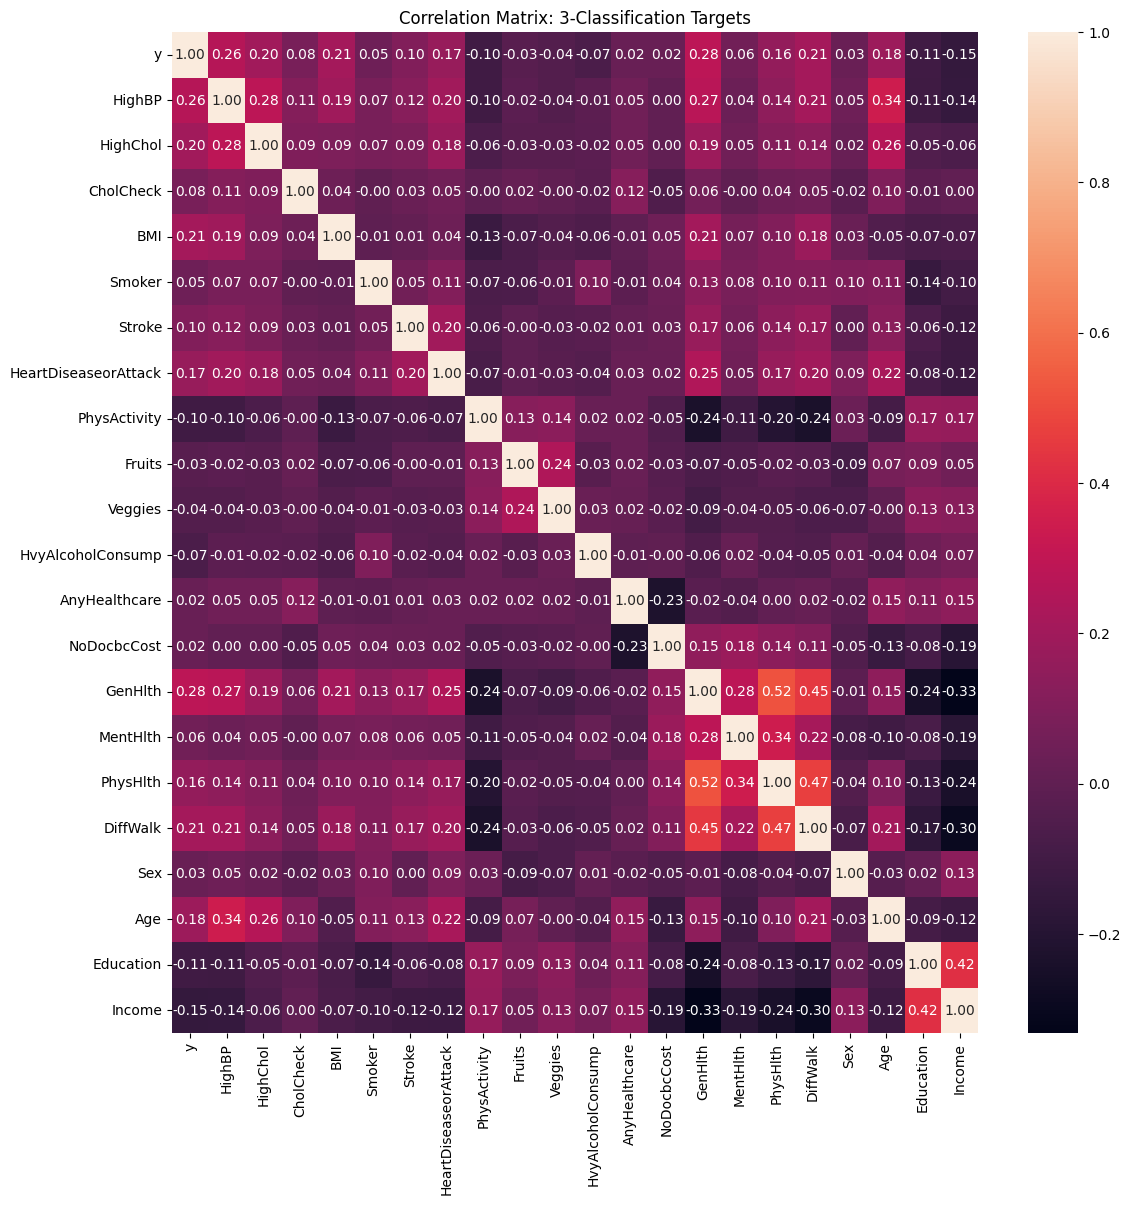

In [13]:
# Correlation matrix for 3-classification targets (healthy, pre-diabetic, diabetic)
plt.figure(figsize = (13, 13))
sns.heatmap(tri_df.corr(), annot = True, fmt = '.2f')
plt.title('Correlation Matrix: 3-Classification Targets')

Text(0.5, 0.98, 'BMI by Target Outcome')

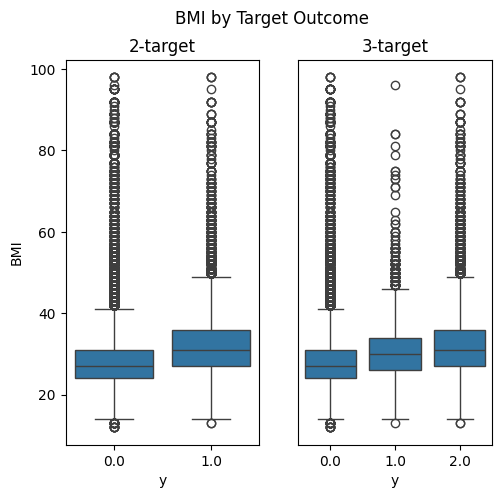

In [14]:
## Figure for boxplots of BMI values related to each of the two datasets
# Prepare the separate data frame for generating the subplot figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(5.5,5))
sns.boxplot(x = bin_df['y'], y = bin_df['BMI'], ax = axes[0])
sns.boxplot(x = tri_df['y'], y = tri_df['BMI'], ax = axes[1])
axes[0].set(title = '2-target')
axes[1].set(title = '3-target', ylabel = None, yticks = [], yticklabels = [])
plt.suptitle('BMI by Target Outcome')

[Text(0.5, 0, '3-target')]

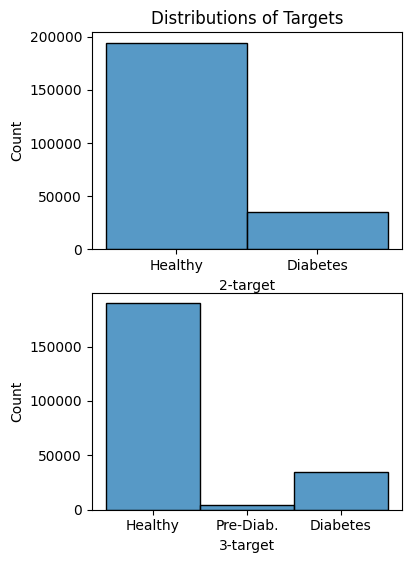

In [15]:
## Figure for distributions of target variables for each of the two datasets
# Prepare the separate data frame for generating the subplot figure
bin_target = bin_df['y'].copy()
bin_target.replace({0: 'Healthy', 1: 'Diabetes'}, inplace = True)
bin_target = pd.Categorical(bin_target, ['Healthy', 'Diabetes'])
tri_target = tri_df['y'].copy()
tri_target.replace({0: 'Healthy', 1: 'Pre-Diab.', 2: 'Diabetes'}, inplace = True)
tri_target = pd.Categorical(tri_target, ['Healthy', 'Pre-Diab.', 'Diabetes'])

# Generate subplot figure
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(4,6.2))
sns.histplot(bin_target, bins = 2, ax = axes[0])
sns.histplot(tri_target, bins = 3, ax = axes[1])
axes[0].set(xlabel = '2-target', title = 'Distributions of Targets')
axes[1].set(xlabel = '3-target')

## Data Cleaning
- Duplicates are dropped before all data visualizations
- Variables are left in ordinal encoding to avoid the use of a scaling factor in future analysis pipelines
- The first education class is eliminated due to an extremely small amount of samples
- Feature engineering is the final project goal, so the process of evaluating the influence of individual factors follows after the parameter grid search
- As a result, although there are many classes that are unbalanced across all factors, elimination of a factor will be tested thoroughly in the coming steps, and we have included all factors in the intial testing phases that follow
- The 3-target dataset has an absurdly small amount of samples for the pre-diabetic class, which also decreases the samples for the diabetic class. As a result, we will focus on the 2-target dataset
- Separating classes manually gives same results as using train_test_split, so only train_test_split results will be maintained

In [16]:
# Clean dataframe with final steps
bin_df['Education'].drop(1, axis = 0, inplace = True)

## Baseline Model Testing

In [17]:
# Separate entire dataset
X_train, X_test, y_train, y_test = train_test_split(bin_df.drop('y', axis = 1), bin_df['y'], test_size = 0.3)

# Separate dataset for health baseline model
health_X_train, health_X_test, health_y_train, health_y_test = train_test_split(bin_df[['GenHlth','MentHlth','PhysHlth']], bin_df['y'], test_size = 0.3)

# Separate dataset for body baseline model
body_X_train, body_X_test, body_y_train, body_y_test = train_test_split(bin_df[['BMI','Sex','Age']], bin_df['y'], test_size = 0.3)

In [18]:
# Fit dummy model and calculate mean accuracy scores for the training and test datasets
start_time = time.time()
dummy_clf = DummyClassifier().fit(X_train, y_train)
dummy_fit_time = (time.time() - start_time)
baseline_train_f1 = f1_score(y_train, dummy_clf.predict(X_train))
baseline_test_f1 = f1_score(y_test, dummy_clf.predict(X_test))
baseline_train_acc = dummy_clf.score(X_train, y_train)
baseline_test_acc = dummy_clf.score(X_test, y_test)

# Fit health model and calculate mean accuracy scores for the training and test datasets
start_time = time.time()
health_tree = DecisionTreeClassifier().fit(health_X_train, health_y_train)
health_fit_time = (time.time() - start_time)
health_tree_train_f1 = f1_score(health_y_train, health_tree.predict(health_X_train))
health_tree_test_f1 = f1_score(health_y_test, health_tree.predict(health_X_test))
health_tree_train_acc = health_tree.score(health_X_train, health_y_train)
health_tree_test_acc = health_tree.score(health_X_test, health_y_test)

# Fit body model and calculate mean accuracy scores for the training and test datasets
start_time = time.time()
body_tree = DecisionTreeClassifier().fit(body_X_train, body_y_train)
body_fit_time = (time.time() - start_time)
body_tree_train_f1 = f1_score(body_y_train, body_tree.predict(body_X_train))
body_tree_test_f1 = f1_score(body_y_test, body_tree.predict(body_X_test))
body_tree_train_acc = body_tree.score(body_X_train, body_y_train)
body_tree_test_acc = body_tree.score(body_X_test, body_y_test)

## Initial Classification Model Testing

In [19]:
# Fit logistic regression classifier and calculate mean accuracy scores for the training and test datasets
start_time = time.time()
lgr = LogisticRegression().fit(X_train, y_train)
lgr_fit_time = (time.time() - start_time)
lgr_train_f1 = f1_score(y_train, lgr.predict(X_train))
lgr_test_f1 = f1_score(y_test, lgr.predict(X_test))
lgr_train_acc = lgr.score(X_train, y_train)
lgr_test_acc = lgr.score(X_test, y_test)

# Fit decision tree classifier and calculate mean accuracy scores for the training and test datasets
start_time = time.time()
tree = DecisionTreeClassifier().fit(X_train, y_train)
tree_fit_time = (time.time() - start_time)
tree_train_f1 = f1_score(y_train, tree.predict(X_train))
tree_test_f1 = f1_score(y_test, tree.predict(X_test))
tree_train_acc = tree.score(X_train, y_train)
tree_test_acc = tree.score(X_test, y_test)

# Fit K nearest neighbors classifier and calculate mean accuracy scores for the training and test datasets
start_time = time.time()
knn = KNeighborsClassifier().fit(X_train, y_train)
knn_fit_time = (time.time() - start_time)
knn_train_f1 = f1_score(y_train, knn.predict(X_train))
knn_test_f1 = f1_score(y_test, knn.predict(X_test))
knn_train_acc = knn.score(X_train, y_train)
knn_test_acc = knn.score(X_test, y_test)

# Fit support vector machine classifier and calculate mean accuracy scores for the training and test datasets
start_time = time.time()
svm = SVC().fit(X_train, y_train)
svm_fit_time = (time.time() - start_time)
svm_train_f1 = f1_score(y_train, svm.predict(X_train))
svm_test_f1 = f1_score(y_test, svm.predict(X_test))
svm_train_acc = svm.score(X_train, y_train)
svm_test_acc = svm.score(X_test, y_test)

In [20]:
# Create dataframe for comparing all initial results
init_models_df = pd.DataFrame({'Baseline-Dummy': [baseline_train_f1, baseline_test_f1, baseline_train_acc, 
                                                  baseline_test_acc, dummy_fit_time],
                        'Baseline-Health': [health_tree_train_f1, health_tree_test_f1, health_tree_train_acc,
                                            health_tree_test_acc, health_fit_time],
                        'Baseline-Body': [body_tree_train_f1, body_tree_test_f1, body_tree_train_acc,
                                          body_tree_test_acc, body_fit_time],
                        'LGR': [lgr_train_f1, lgr_test_f1, lgr_train_acc, lgr_test_acc, lgr_fit_time],
                        'DT': [tree_train_f1, tree_test_f1, tree_train_acc, tree_test_acc, tree_fit_time],
                        'KNN': [knn_train_f1, knn_test_f1, knn_train_acc, knn_test_acc, knn_fit_time],
                        'SVM': [svm_train_f1, svm_test_f1, svm_train_acc, svm_test_acc, svm_fit_time]})
init_models_df.rename({0: 'Train F1', 1: 'Test F1', 2: 'Train Accuracy', 3: 'Test Accuracy', 4: 'Fit Time (s)'}, axis = 0, inplace = True)
init_models_df.head()

,Baseline-Dummy,Baseline-Health,Baseline-Body,LGR,DT,KNN,SVM
Train F1,0.000000,0.030224,0.059793,0.203226,0.984206,0.451653,0.023575
Test F1,0.000000,0.016343,0.047884,0.209785,0.300228,0.259065,0.023277
Train Accuracy,0.847053,0.848591,0.849444,0.849307,0.995244,0.874246,0.847869
Test Accuracy,0.847058,0.846128,0.845765,0.850079,0.772686,0.831995,0.847624
Fit Time (s),0.005057,0.041331,0.059401,0.491750,0.443458,0.010698,828.062311


### Evaluation
- **F1 score will be the evaluation metric used throughout the project**
- **F1 score was chosen due to the inconsistency in target classes, and our preference for determining what variables are related to accepting the long-term deposit offer**
- **Since F1 will be the evaluation metric, using it as a scoring metric additionally will be tested**
- In the initial calculations, accuracy is used as a comparison point for the F1 score. The beahvior exemplified for the accuracy metric is conistent for the 3 baselines and the support vector machine model. In all for cases, performance with F1 is abysmal. Although accuracy shows some modulations, they do not mirror F1 score performance. Due the target class disparity, F1 score must be trusted before accuracy.
- 3 baseline models are used for comparison purposes: dummy model, health model, and body model
- The separate baseline models allow us to get an initial idea of the influence that certain factors have on the efficacy of the classification models

### Initial Conclusions
- The dataset is massive, evidenced by the enormous difference in processing times
- The support vector machine is the classifier with the worst results, a;though with the greatest consistency between training and testing data sets in terms of accuracy and F1, and also with an overwhelmingly large processing time. Because of the F1 score performance, it will be omitted moving forward.
- A large different between training and testing F1 indicates a noticeable degree of overfitting, so the most stable performance from our individual models is from the LGR model used for classification purposes. 
- The baseline models (dummy, health and body) perform abysmally, especially compared to our other classification models

## Grid Search for Optimizing Parameters

In [21]:
# Since most variables are codified in ordinal scale, we only need to use StandardScaler for BMI
final_transformer = ColumnTransformer(
    [('scale', StandardScaler(), ['BMI'])],
     remainder = 'passthrough')

# Create dictionary for assessing models with parameter values to be tested
models = {
    'lgr': (LogisticRegression(max_iter=10000), {'lgr__C': [0.01, 0.1, 1, 10]}),
    'tree': (DecisionTreeClassifier(), {'tree__max_depth': [1, 3, 5, 7, 9, 11]}),
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [1, 3, 5, 7, 9, 11]})
}

In [22]:
# Declare variables used to store values calculated within the grid search loop
names = []
train_f1 = []
test_f1 = []
train_acc = []
test_acc = []
fit_times = []
best_params = []
final_models = {}

# Run initial round of grid search, varying parameters for all 4 model types
for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', final_transformer),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid = params, cv = 5, n_jobs = -1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = f1_score(y_train, best_model.predict(X_train))
    test_score = f1_score(y_test, best_model.predict(X_test))
    
    # Append the results
    final_models[name] = grid_search
    train_f1.append(train_score)
    test_f1.append(test_score)
    train_acc.append(best_model.score(X_train, y_train))
    test_acc.append(best_model.score(X_test, y_test))
    fit_times.append(fit_time)
    best_params.append(grid_search.best_params_)
    names.append(name)

In [23]:
# Generate dataframe for storing the results from initial grid search
grid_df = pd.DataFrame({'Model': names, 'Train Time': fit_times, 'Train F1': train_f1, 'Test F1': test_f1, 'Train Accuracy': train_acc, 'Test Accuracy': test_acc, 'Best Parameters': best_params})
grid_df.set_index('Model')
grid_df.head()

,Model,Train Time,Train F1,Test F1,Train Accuracy,Test Accuracy,Best Parameters
0,lgr,5.859229,0.233114,0.235434,0.850290,0.850936,{'lgr__C': 0.1}
1,tree,0.437686,0.200302,0.199012,0.851865,0.851619,{'tree__max_depth': 5}
2,knn,16.868471,0.306490,0.206739,0.861839,0.843383,{'knn__n_neighbors': 11}


#### Models and parameters tested in grid search
- For KNN, originally tested n_neighbors = [1, 3, 5, 7, 9, 11]
- For LGR, originally tested C = [0.01, 0.1, 1, 10]
- For DT, originally tested max_depth = [1, 3, 5, 7, 9, 11]

#### Best and worst models (optimum parameters)
- KNN (n_neighbors = 1)
- LGR (C = 1)
- DT (max_depth = 9)
- **Best model = Logistic regression (slight improvement from train to test, best scores overall)**
- **Worst model = KNN (massive drop off between training set and test set F1 scores)**

## Feature importance from differing models
Feature importance is gauged using permutation importance. This method assigns positive values and negative values, where negative values mean that the feature is more useful in its random permutations than its original state. Given this, we will isolate features with negative or 0 values, and then coordinate which features are weakest for all 3 models in order to try and improve the classification performance of all models. Eliminated features will be consistent across models for maintaining comparison capabilities.

**Results derived from this process could depend on iteration and the process of optimization is effective regardless of which values or chosen in particular**

In [24]:
# Feature improtance from Logistic Regression and generating a dataframe for visualization
perm_importances_lgr = permutation_importance(final_models['lgr'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_lgr = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_lgr.importances_mean})
perm_importances_lgr = perm_importances_lgr.sort_values(by='importance', ascending=False)

# Feature importance from Decision Tree and generating a dataframe for visualization
perm_importances_tree = permutation_importance(final_models['tree'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importance_tree_df = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_tree.importances_mean})
perm_importance_tree_df = perm_importance_tree_df.sort_values(by='importance', ascending=False)

# Feature importance using permutation for KNN and generating a dataframe for visualization
result_knn = permutation_importance(final_models['knn'], X_test, y_test, n_repeats=10, random_state=42, n_jobs = -1)
perm_importances_knn = pd.DataFrame({'feature': X_train.columns, 'importance': result_knn.importances_mean})
perm_importances_knn = perm_importances_knn.sort_values(by='importance', ascending=False)

In [25]:
# Visualize feature importance for logistic regression results
perm_importances_lgr.head(22)

,feature,importance
3,BMI,0.008007
13,GenHlth,0.006336
0,HighBP,0.002571
1,HighChol,0.002079
18,Age,0.001101
17,Sex,0.000551
2,CholCheck,0.000401
15,PhysHlth,0.000353
10,HvyAlcoholConsump,0.000353
5,Stroke,0.000144


In [26]:
# Visualize feature importance for decision tree results
perm_importance_tree_df.head(22)

,feature,importance
3,BMI,0.006743
13,GenHlth,0.005839
1,HighChol,0.004292
0,HighBP,0.003277
12,NoDocbcCost,0.000000
19,Education,0.000000
18,Age,0.000000
17,Sex,0.000000
16,DiffWalk,0.000000
15,PhysHlth,0.000000


In [27]:
# Visualize feature importance for k nearest neighbors results
perm_importances_knn.head(22)

,feature,importance
3,BMI,0.004975
13,GenHlth,0.003091
18,Age,0.001923
1,HighChol,0.000954
17,Sex,0.000584
8,Fruits,0.000110
6,HeartDiseaseorAttack,0.000107
15,PhysHlth,0.000041
11,AnyHealthcare,0.000010
10,HvyAlcoholConsump,-0.000007


#### Feature importance summarized
- LGR (best performing model in terms of stability and F1 scores): 
    - Most important parameters: BMI, GenHlth, HighBP, HighChol, Age
    - Least important parameters: Income, PhysActivity, Smoker, NoDocbcCost, Veggies
- DT (comparable stability but lower F1 scores):
    - Most important parameters: BMI, GenHlth, HighChol, HighBP
    - Least important parameters: Income, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, AnyHealthcare, HvyAlcoholConsump, MentHlth, PhysHlth, DiffWalk, Sex, Age, Education, NoDocbcCost
- KNN (greater train F1 and comparable test F1):
    - Most important parameters: GenHlth, BMI, Age, HighBP, HighChol
    - Least important parameters: Education, Veggies, HighBP, Smoker, Income, PhysActivity, NoDocbcCost, MentHlth, DiffWalk, Chol Check, Stroke, HvyAlcoholConsump

#### Best features
- GenHlth
- BMI
- HighBP
- HighChol
- Age

#### Features to eliminate
- Income
- PhysActivity
- Smoker
- NoDocbcCost
- Veggies

In [37]:
# Split dataset while eliminating features
X_train, X_test, y_train, y_test = train_test_split(bin_df.drop(['Income', 'PhysActivity', 'Smoker', 'Veggies', 'NoDocbcCost', 'y'], axis = 1), bin_df['y'], test_size = 0.3)

In [38]:
# Since most variables are codified in ordinal scale, we only need to use StandardScaler for BMI
final_transformer = ColumnTransformer(
    [('scale', StandardScaler(), ['BMI'])],
     remainder = 'passthrough')

# Create dictionary for assessing models with parameter values to be tested
models = {
    'lgr': (LogisticRegression(max_iter=10000), {'lgr__C': [0.01, 0.1, 1, 10]}),
    'tree': (DecisionTreeClassifier(), {'tree__max_depth': [1, 3, 5, 7, 9, 11]}),
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [1, 3, 5, 7, 9]})
}

In [ ]:
# Repear GridSearchCV for newly pruned dataset to see if it improves individual models' classification abilities
# Declare variables used to store values calculated within the grid search loop
names = []
train_f1 = []
test_f1 = []
train_acc = []
test_acc = []
fit_times = []
best_params = []
final_models = {}

# Run initial round of grid search, varying parameters for all 4 model types
for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', final_transformer),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid = params, cv = 5, n_jobs = -1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = f1_score(y_train, best_model.predict(X_train))
    test_score = f1_score(y_test, best_model.predict(X_test))
    
    # Append the results
    final_models[name] = grid_search
    train_f1.append(train_score)
    test_f1.append(test_score)
    train_acc.append(best_model.score(X_train, y_train))
    test_acc.append(best_model.score(X_test, y_test))
    fit_times.append(fit_time)
    best_params.append(grid_search.best_params_)
    names.append(name)

In [40]:
# Generate dataframe for storing the results from initial grid search
new_grid_df = pd.DataFrame({'Model': names, 'Train Time': fit_times, 'Train F1': train_f1, 'Test F1': test_f1, 'Train Accuracy': train_acc, 
                            'Test Accuracy': test_acc, 'Best Parameters': best_params})
new_grid_df.set_index('Model')
new_grid_df.head()

,Model,Train Time,Train F1,Test F1,Train Accuracy,Test Accuracy,Best Parameters
0,lgr,1.818258,0.235455,0.236251,0.850533,0.849919,{'lgr__C': 10}
1,tree,0.235913,0.153583,0.155654,0.852195,0.850762,{'tree__max_depth': 7}
2,knn,11.392883,0.357437,0.249433,0.864964,0.841335,{'knn__n_neighbors': 9}


In [41]:
grid_df.head()

,Model,Train Time,Train F1,Test F1,Train Accuracy,Test Accuracy,Best Parameters
0,lgr,5.859229,0.233114,0.235434,0.850290,0.850936,{'lgr__C': 0.1}
1,tree,0.437686,0.200302,0.199012,0.851865,0.851619,{'tree__max_depth': 5}
2,knn,16.868471,0.306490,0.206739,0.861839,0.843383,{'knn__n_neighbors': 11}


## Testing ensemble techniques
**We will take the new dataset with eliminated features to test ensemble techniques**
- AdaBoostClassifier
- BaggingClassifier
- ExtraTreesClassifier
- GradientBoostingClassifier
- HistGradientBoostingClassifier
- RandomForestClassifier
- StackingClassifier
- VotingClassifier

In [43]:
# Basic order of models that matches previous syntax, with optimized parameters specified
clfs = [('lgr', LogisticRegression(max_iter = 10000, C = 1)), 
        ('tree', DecisionTreeClassifier(max_depth = 5)),
        ('knn', KNeighborsClassifier(n_neighbors = 9))]

In [44]:
# Declare and fit voting classifier
voter = VotingClassifier(estimators = clfs)
start_time = time.time()
voter.fit(X_train, y_train)
# Calculate fit time for voting classifier
voter_fit_time = (time.time() - start_time)
# Calculate F1 scores for voting classifier
voter_train_f1 = f1_score(y_train, voter.predict(X_train))
voter_test_f1 = f1_score(y_test, voter.predict(X_test))
voter_train_acc = voter.score(X_train, y_train)
voter_test_acc = voter.score(X_test, y_test)

# Declare and fit random forest classifier
rf = RandomForestClassifier(n_estimators = 100, max_depth = 5)
start_time = time.time()
rf.fit(X_train, y_train)
# Calculate fit time for random forest classifier
rf_fit_time = (time.time() - start_time)
# Calculate F1 scores for random forest classifier
rf_train_f1 = f1_score(y_train, rf.predict(X_train))
rf_test_f1 = f1_score(y_test, rf.predict(X_test))
# Calculate accuracy for contextual reference
rf_train_acc = rf.score(X_train, y_train)
rf_test_acc = rf.score(X_test, y_test)

# Declare and fit extra trees classifier
ext = ExtraTreesClassifier(n_estimators = 100, max_depth = 5)
start_time = time.time()
ext.fit(X_train, y_train)
# Calculate fit time for extra trees classifier
ext_fit_time = (time.time() - start_time)
# Calculate F1 scores for extra trees classifier
ext_train_f1 = f1_score(y_train, ext.predict(X_train))
ext_test_f1 = f1_score(y_test, ext.predict(X_test))
# Calculate accuracy for contextual reference
ext_train_acc = ext.score(X_train, y_train)
ext_test_acc = ext.score(X_test, y_test)

# Declare and fit gradient boosting classifier
gbc = GradientBoostingClassifier()
start_time = time.time()
gbc.fit(X_train, y_train)
# Calculate fit time for gradient boosting classifier
gbc_fit_time = (time.time() - start_time)
# Calculate F1 scores for gradient boosting classifier
gbc_train_f1 = f1_score(y_train, gbc.predict(X_train))
gbc_test_f1 = f1_score(y_test, gbc.predict(X_test))
# Calculate accuracy for contextual reference
gbc_train_acc = gbc.score(X_train, y_train)
gbc_test_acc = gbc.score(X_test, y_test)

# Declare and fit stacking classifier
stc = StackingClassifier(estimators = clfs)
start_time = time.time()
stc.fit(X_train, y_train)
# Calculate fit time for stacking classifier
stc_fit_time = (time.time() - start_time)
# Calculate F1 scores for stacking classifier
stc_train_f1 = f1_score(y_train, stc.predict(X_train))
stc_test_f1 = f1_score(y_test, stc.predict(X_test))
# Calculate accuracy for contextual reference
stc_train_acc = stc.score(X_train, y_train)
stc_test_acc = stc.score(X_test, y_test)

# Declare and fit histogram gradient boosting classifier
hgb = HistGradientBoostingClassifier()
start_time = time.time()
hgb.fit(X_train, y_train)
# Calculate fit time for histogram gradient boost classifier
hgb_fit_time = (time.time() - start_time)
# Calculate F1 scores for stacking classifier
hgb_train_f1 = f1_score(y_train, hgb.predict(X_train))
hgb_test_f1 = f1_score(y_test, hgb.predict(X_test))
# Calculate accuracy for contextual reference
hgb_train_acc = hgb.score(X_train, y_train)
hgb_test_acc = hgb.score(X_test, y_test)

# Declare and fit AdaBoost classifier
ada = AdaBoostClassifier()
start_time = time.time()
ada.fit(X_train, y_train)
# Calculate fit time for AdaBoost classifier
ada_fit_time = (time.time() - start_time)
# Calculate F1 scores for stacking classifier
ada_train_f1 = f1_score(y_train, ada.predict(X_train))
ada_test_f1 = f1_score(y_test, ada.predict(X_test))
# Calculate accuracy for contextual reference
ada_train_acc = ada.score(X_train, y_train)
ada_test_acc = ada.score(X_test, y_test)

In [45]:
# Create dataframe for comparing all initial results from ensemble techniques
ensemble_df = pd.DataFrame({'Voter': [voter_train_f1, voter_test_f1, voter_train_acc, voter_test_acc, voter_fit_time],
                        'RandomForest': [rf_train_f1, rf_test_f1, rf_train_acc, rf_test_acc, rf_fit_time],
                        'ExtraTrees': [ext_train_f1, ext_test_f1, ext_train_acc, ext_test_acc, ext_fit_time],
                        'GradBoost': [gbc_train_f1, gbc_test_f1, gbc_train_acc, gbc_test_acc, gbc_fit_time],
                        'Stack': [stc_train_f1, stc_test_f1, stc_train_acc, stc_test_acc, stc_fit_time],
                        'HistGradB': [hgb_train_f1, hgb_test_f1, hgb_train_acc, hgb_test_acc, hgb_fit_time],
                        'AdaBoost': [ada_train_f1, ada_test_f1, ada_train_acc, ada_test_acc, ada_fit_time]})
ensemble_df.rename({0: 'Train F1', 1: 'Test F1', 2: 'Train Accuracy', 3: 'Test Accuracy', 4: 'Fit Time (s)'}, axis = 0, inplace = True)
ensemble_df.head()

,Voter,RandomForest,ExtraTrees,GradBoost,Stack,HistGradB,AdaBoost
Train F1,0.223615,0.038173,0.005128,0.250328,0.294546,0.259262,0.242440
Test F1,0.210372,0.043113,0.004327,0.256425,0.281857,0.246424,0.254654
Train Accuracy,0.855744,0.849101,0.847825,0.854356,0.855787,0.856852,0.851069
Test Accuracy,0.851590,0.847828,0.846230,0.853333,0.851662,0.853057,0.851110
Fit Time (s),1.659273,3.331593,2.617142,8.279279,19.858924,1.203425,2.046336


#### Best emsemble technique performance
- Stack classifier (slight train-test increase)
- GradBoost classifier (slight train-test increase)
- HistGradB
- AdaBoost
- Voting classifier

The choice to eliminate accuracy due to its inability to discern between individual performances as a metric for comparison between models has been verified for ensemble techniques as well. Again, accuracy will be omitted moving forward.

In [46]:
# Declare dataframe for storing final values of stacking classifier test
stack_test = pd.DataFrame(index = ['KNN Last', 'LGR Last', 'DT Last'], columns = ['Train F1', 'Test F1', 'Fit Time'])

# Order models with KNN as last classifier
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)), 
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),
             ('knn', KNeighborsClassifier(n_neighbors = 9))]
stc_knn = StackingClassifier(estimators = ord_clfs)
start_time = time.time()
stc_knn.fit(X_train, y_train)
stc_knn_fit_time = (time.time() - start_time)
stc_knn_train_f1 = f1_score(y_train, stc_knn.predict(X_train))
stc_knn_test_f1 = f1_score(y_test, stc_knn.predict(X_test))
stack_test.loc['KNN Last', :] = [stc_knn_train_f1, stc_knn_test_f1, stc_knn_fit_time]

# Order models with LGR as last classifier
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)), 
             ('knn', KNeighborsClassifier(n_neighbors = 9)),
             ('lgr', LogisticRegression(max_iter = 10000, C = 1))]
stc_lgr = StackingClassifier(estimators = ord_clfs)
start_time = time.time()
stc_lgr.fit(X_train, y_train)
stc_lgr_fit_time = (time.time() - start_time)
stc_lgr_train_f1 = f1_score(y_train, stc_lgr.predict(X_train))
stc_lgr_test_f1 = f1_score(y_test, stc_lgr.predict(X_test))
stack_test.loc['LGR Last', :] = [stc_lgr_train_f1, stc_lgr_test_f1, stc_lgr_fit_time]

# Order models with DT as last classifier
ord_clfs = [('knn', KNeighborsClassifier(n_neighbors = 9)),
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),
             ('tree', DecisionTreeClassifier(max_depth = 5))]
stc_dt = StackingClassifier(estimators = ord_clfs)
start_time = time.time()
stc_dt.fit(X_train, y_train)
stc_dt_fit_time = (time.time() - start_time)
stc_dt_train_f1 = f1_score(y_train, stc_dt.predict(X_train))
stc_dt_test_f1 = f1_score(y_test, stc_dt.predict(X_test))
stack_test.loc['DT Last', :] = [stc_dt_train_f1, stc_dt_test_f1, stc_dt_fit_time]

stack_test.head()

,Train F1,Test F1,Fit Time
KNN Last,0.294546,0.281857,17.648249
LGR Last,0.294546,0.281857,17.354463
DT Last,0.294546,0.281857,17.771203


In [51]:
#Declare dataframe for storing final values of voting classifier test
vote_test = pd.DataFrame(index = ['Soft Vote', 'LGR Weight Vote', 'KNN Weight Vote', 'DT Weight Vote'], columns = ['Train F1', 'Test F1', 'Fit Time'])

# Test soft voting scheme
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)), 
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),
             ('knn', KNeighborsClassifier(n_neighbors = 9))]
v_soft = VotingClassifier(estimators = ord_clfs, voting = 'soft')
start_time = time.time()
v_soft.fit(X_train, y_train)
v_soft_fit_time = (time.time() - start_time)
v_soft_train_f1 = f1_score(y_train, v_soft.predict(X_train))
v_soft_test_f1 = f1_score(y_test, v_soft.predict(X_test))
vote_test.loc['Soft Vote', :] = [v_soft_train_f1, v_soft_test_f1, v_soft_fit_time]


# Test weighted voting scheme, with LGR weighted most
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)), 
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),
             ('knn', KNeighborsClassifier(n_neighbors = 9))]
v_weight_lgr = VotingClassifier(estimators = ord_clfs, voting = 'soft', weights = [0.25, 0.5, 0.25])
start_time = time.time()
v_weight_lgr.fit(X_train, y_train)
v_weight_lgr_fit_time = (time.time() - start_time)
v_weight_lgr_train_f1 = f1_score(y_train, v_weight_lgr.predict(X_train))
v_weight_lgr_test_f1 = f1_score(y_test, v_weight_lgr.predict(X_test))
vote_test.loc['LGR Weight Vote', :] = [v_weight_lgr_train_f1, v_weight_lgr_test_f1, v_weight_lgr_fit_time]

# Test weighted voting scheme, with DT weighted most
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)), 
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),
             ('knn', KNeighborsClassifier(n_neighbors = 9))]
v_weight_dt = VotingClassifier(estimators = ord_clfs, voting = 'soft', weights = [0.5, 0.25, 0.25])
start_time = time.time()
v_weight_dt.fit(X_train, y_train)
v_weight_dt_fit_time = (time.time() - start_time)
v_weight_dt_train_f1 = f1_score(y_train, v_weight_dt.predict(X_train))
v_weight_dt_test_f1 = f1_score(y_test, v_weight_dt.predict(X_test))
vote_test.loc['DT Weight Vote', :] = [v_weight_dt_train_f1, v_weight_dt_test_f1, v_weight_dt_fit_time]

# Test weighted voting scheme, with KNN weighted most
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)), 
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),
             ('knn', KNeighborsClassifier(n_neighbors = 9))]
v_weight_knn = VotingClassifier(estimators = ord_clfs, voting = 'soft', weights = [0.25, 0.25, 0.5])
start_time = time.time()
v_weight_knn.fit(X_train, y_train)
v_weight_knn_fit_time = (time.time() - start_time)
v_weight_knn_train_f1 = f1_score(y_train, v_weight_knn.predict(X_train))
v_weight_knn_test_f1 = f1_score(y_test, v_weight_knn.predict(X_test))
vote_test.loc['KNN Weight Vote', :] = [v_weight_knn_train_f1, v_weight_knn_test_f1, v_weight_knn_fit_time]

vote_test.head()

,Train F1,Test F1,Fit Time
Soft Vote,0.220531,0.189097,1.74901
LGR Weight Vote,0.219354,0.197397,1.795725
KNN Weight Vote,0.251113,0.196416,1.721888
DT Weight Vote,0.20114,0.187107,1.749312


#### Best ensemble technique:
- Tested ordering of models but did not improve performance of stacking classifier, so only need to consider the above metrics
- Tested distinct voting schemes, but did not change result significantly enough to outperform stacking classifier
- Voting classifier works best for training set when KNN is weighted heaviest, while the best test score is for when LGR is weighted heaviest, with a very slight difference
- **Stacking classifier is the best ensemble technique, regardless of order**

## Testing feature importance of ensemble techniques
- Start by observing feature importance for best boosting techniques
- Follow up with focus on best ensemble models, voting classifier then stacking classifier
- Test further refining data for best classifiers by eliminating all negative permutation importance features as final check
- For voting classifier, LGR weight vote will be used
- For stacking classifier, LGR will be used since all 3 results are identical, for consistency with voting classifier

In [52]:
boosting = pd.DataFrame(index = ada.feature_names_in_, columns = ['AdaBoost', 'GradientBoost'])
boosting['AdaBoost'] = ada.feature_importances_
boosting['GradientBoost'] = gbc.feature_importances_
boosting.sort_values('AdaBoost', inplace = True, ascending = False)
boosting.head(30)

,AdaBoost,GradientBoost
HighBP,0.390843,0.288396
GenHlth,0.158125,0.259888
Age,0.138054,0.086583
CholCheck,0.114658,0.006547
BMI,0.082423,0.180106
HvyAlcoholConsump,0.049878,0.013884
HighChol,0.037085,0.086207
Sex,0.016470,0.006724
HeartDiseaseorAttack,0.012465,0.026704
Stroke,0.000000,0.003857


In [53]:
boosting.sort_values('GradientBoost', inplace = True, ascending = False)
boosting.head(30)

,AdaBoost,GradientBoost
HighBP,0.390843,0.288396
GenHlth,0.158125,0.259888
BMI,0.082423,0.180106
Age,0.138054,0.086583
HighChol,0.037085,0.086207
DiffWalk,0.000000,0.031198
HeartDiseaseorAttack,0.012465,0.026704
HvyAlcoholConsump,0.049878,0.013884
Sex,0.016470,0.006724
CholCheck,0.114658,0.006547


Although boosting models do not perform as well as the stacking classifier, the most significant features mirror the previous results from individual models. While boosting models outperforms the voting classifier model, we have modifications that may affect the voting classifier's inferior position.

In [54]:
# Coefficients from Voting Classifier
perm_importances_voter = permutation_importance(v_weight_knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_voter = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_voter.importances_mean})
perm_importances_voter = perm_importances_voter.sort_values(by='importance', ascending=False)

# Coefficients from Stacking Classifier
perm_importances_stack = permutation_importance(stc_lgr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_stack = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_stack.importances_mean})
perm_importances_stack = perm_importances_stack.sort_values(by='importance', ascending=False)

In [55]:
perm_importances_voter.head(30)

,feature,importance
3,BMI,0.006898
9,GenHlth,0.004952
14,Age,0.001881
0,HighBP,0.001607
1,HighChol,0.001403
5,HeartDiseaseorAttack,0.000519
4,Stroke,0.000359
13,Sex,0.000263
12,DiffWalk,0.000203
7,HvyAlcoholConsump,0.000121


**Eliminate following negative features from voting classifier dataset initially**
- AnyHealthcare
- MentHlth
- Education
- Fruits

In [58]:
perm_importances_stack.head(30)

,feature,importance
3,BMI,0.010042
9,GenHlth,0.008794
1,HighChol,0.003652
0,HighBP,0.003159
14,Age,0.002028
11,PhysHlth,0.000632
10,MentHlth,0.000423
7,HvyAlcoholConsump,0.000410
2,CholCheck,0.000321
13,Sex,0.000221


In [ ]:
# Split dataset while eliminating features for voting classifier test
X_train, X_test, y_train, y_test = train_test_split(bin_df.drop(['Income', 'PhysActivity', 'Smoker', 'Veggies', 'NoDocbcCost', 'AnyHealthcare', 'MentHlth', 'Education', 'Fruits', 'y'], axis = 1), bin_df['y'], test_size = 0.3)

# Declare dataframe for storing final values of voting classifier test. Including original results for comparison, marked with "Prev"
vote_mod = pd.DataFrame(index = ['LGR Weight Vote', 'LGR Weight Prev'], columns = ['Train F1', 'Test F1', 'Fit Time'])

# Rerun best voting classifier model with modified dataset to see if performance improves (declare models, fit classifier, calculate fit time and F1 scores)
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)),
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),
             ('knn', KNeighborsClassifier(n_neighbors = 9))]
vote_weight = VotingClassifier(estimators = ord_clfs, voting = 'soft', weights = [0.25, 0.5, 0.25])
start_time = time.time()
vote_weight.fit(X_train, y_train)
vote_weight_fit_time = (time.time() - start_time)
vote_weight_train_f1 = f1_score(y_train, vote_weight.predict(X_train))
vote_weight_test_f1 = f1_score(y_test, vote_weight.predict(X_test))
vote_mod.loc['LGR Weight Vote', :] = [vote_weight_train_f1, vote_weight_test_f1, vote_weight_fit_time]
vote_mod.loc['LGR Weight Prev', :] = vote_test.loc['LGR Weight Vote',:]
vote_mod.head()

# Coefficients from voting classifier to verify elimination of all negative values
perm_importances_voter_clean = permutation_importance(vote_weight, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_voter_clean = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_voter_clean.importances_mean})
perm_importances_voter_clean = perm_importances_voter_clean.sort_values(by='importance', ascending=False)

# Printing the permutation feature importance results so the F1 score dataframe can be visualized directly below
print("\nPermutation importance from Voting Classifier:")
print(perm_importances_voter_clean)
vote_mod.head()


Permutation importance from Voting Classifier:
                 feature  importance
3                    BMI    0.007267
7                GenHlth    0.005935
1               HighChol    0.001884
0                 HighBP    0.001849
11                   Age    0.001582
6      HvyAlcoholConsump    0.000398
5   HeartDiseaseorAttack    0.000353
2              CholCheck    0.000084
9               DiffWalk    0.000060
10                   Sex   -0.000025
8               PhysHlth   -0.000096
4                 Stroke   -0.000155


,Train F1,Test F1,Fit Time
LGR Weight Vote,0.237581,0.210404,1.37094
LGR Weight Prev,0.219354,0.197397,1.795725


#### I will attempt to optimize the voting and stacking ensemble techniques by eliminating all negative feature values from permutation importance.
- **If there are still negative features after initial test, I will rerun the same cells with the problematic (negative features) excluded**
- From initial run, eliminate following features additionally:
    - Voting classifier: Sex, PhysHlth, Stroke

In [70]:
# Split dataset while eliminating features for final voting classifier test
X_train, X_test, y_train, y_test = train_test_split(bin_df.drop(['Income', 'PhysActivity', 'Smoker', 'Veggies', 'NoDocbcCost', 'AnyHealthcare', 'MentHlth', 'Education', 'Fruits',
                                                                 'Sex', 'PhysHlth', 'Stroke', 'y'], axis = 1), bin_df['y'], test_size = 0.3)

# Declare dataframe for storing previous optimal outocmes to compare with pruning outcome
vote_prune = pd.DataFrame(index = ['LGR Weight Prune', 'LGR Weight Mod', 'LGR Weight Prev'], columns = ['Train F1', 'Test F1', 'Fit Time'])

# Rerun best voting classifier model with pruned dataset from prior voting classifier results
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)),
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),
             ('knn', KNeighborsClassifier(n_neighbors = 9))]
vote_pruned = VotingClassifier(estimators = ord_clfs, voting = 'soft', weights = [0.25, 0.5, 0.25])
start_time = time.time()
vote_pruned.fit(X_train, y_train)
vote_pruned_fit_time = (time.time() - start_time)
vote_pruned_train_f1 = f1_score(y_train, vote_pruned.predict(X_train))
vote_pruned_test_f1 = f1_score(y_test, vote_pruned.predict(X_test))
vote_prune.loc['LGR Weight Prune', :] = [vote_pruned_train_f1, vote_pruned_test_f1, vote_pruned_fit_time]
vote_prune.loc['LGR Weight Mod', :] = vote_mod.loc['LGR Weight Vote',:]
vote_prune.loc['LGR Weight Prev', :] = vote_test.loc['LGR Weight Vote',:]
vote_prune.head()

# Coefficients from voting classifier to verify elimination of all negative values
perm_importances_voter_prune = permutation_importance(vote_pruned, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_voter_prune = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_voter_prune.importances_mean})
perm_importances_voter_prune = perm_importances_voter_prune.sort_values(by='importance', ascending=False)

# Printing the permutation feature importance results so the F1 score dataframe can be visualized directly below
print("\nPermutation importance from Voting Classifier (modfified):")
print(perm_importances_voter_prune)
vote_prune.head()


Permutation importance from Voting Classifier (modfified):
                feature  importance
3                   BMI    0.007150
6               GenHlth    0.006314
0                HighBP    0.002670
1              HighChol    0.002597
8                   Age    0.001688
4  HeartDiseaseorAttack    0.000474
7              DiffWalk    0.000315
5     HvyAlcoholConsump    0.000227
2             CholCheck    0.000167


,Train F1,Test F1,Fit Time
LGR Weight Prune,0.229877,0.212532,0.662675
LGR Weight Mod,0.237581,0.210404,1.37094
LGR Weight Prev,0.219354,0.197397,1.795725


**Eliminate following negative features from stacking classifier dataset initially**
- AnyHealthcare
- Stroke
- DiffWalk

In [71]:
# Split dataset while eliminating features for stacking classifier test
X_train, X_test, y_train, y_test = train_test_split(bin_df.drop(['Income', 'PhysActivity', 'Smoker', 'Veggies', 'NoDocbcCost', 'AnyHealthcare', 'Stroke', 'DiffWalk', 'y'], axis = 1), bin_df['y'], test_size = 0.3)

# Declare dataframe for storing final values of stacking classifier test. Including original results for comparison, marked with "Prev"
stack_mod = pd.DataFrame(index = ['LGR Last', 'LGR Prev'], columns = ['Train F1', 'Test F1', 'Fit Time'])

# Rerun best stacking classifier model with modified dataset to see if performance improves (declare models, fit classifier, calculate fit time and F1 scores)
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)),
             ('knn', KNeighborsClassifier(n_neighbors = 9)),
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),]
stack = StackingClassifier(estimators = ord_clfs)
start_time = time.time()
stack.fit(X_train, y_train)
stack_fit_time = (time.time() - start_time)
stack_train_f1 = f1_score(y_train, stack.predict(X_train))
stack_test_f1 = f1_score(y_test, stack.predict(X_test))
stack_mod.loc['LGR Last', :] = [stack_train_f1, stack_test_f1, stack_fit_time]
stack_mod.loc['LGR Prev', :] = stack_test.loc['LGR Last', :]

# Coefficients from stacking classifier to verify elimination of all negative values
perm_importances_stack_clean = permutation_importance(stack, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_stack_clean = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_stack_clean.importances_mean})
perm_importances_stack_clean = perm_importances_stack_clean.sort_values(by='importance', ascending=False)

# Printing the permutation feature importance results so the F1 score dataframe can be visualized directly below
print("\nPermutation importance from Stacking Classifier clean:")
print(perm_importances_stack_clean)
stack_mod.head()


Permutation importance from Stacking Classifier clean:
                 feature  importance
3                    BMI    0.009567
7                GenHlth    0.008137
0                 HighBP    0.002622
1               HighChol    0.001890
11                   Age    0.001453
6      HvyAlcoholConsump    0.000568
9               PhysHlth    0.000401
10                   Sex    0.000147
8               MentHlth    0.000089
2              CholCheck    0.000001
4   HeartDiseaseorAttack   -0.000097
5                 Fruits   -0.000109
12             Education   -0.000259


,Train F1,Test F1,Fit Time
LGR Last,0.29592,0.272306,16.127018
LGR Prev,0.294546,0.281857,17.354463


#### I will attempt to optimize the stacking ensemble techniques by eliminating all negative feature values from permutation importance.
- **If there are still negative features after initial test, I will rerun the same cells with the problematic (negative features) excluded**
- From initial run, eliminate following features additionally:
    - Stacking classifier: HeartDiseaseorAttack, Fruits, Education, MentHlth

In [78]:
# Split dataset while eliminating features for final stacking classifier test
X_train, X_test, y_train, y_test = train_test_split(bin_df.drop(['Income', 'PhysActivity', 'Smoker', 'Veggies', 'NoDocbcCost', 'AnyHealthcare', 'Stroke', 'DiffWalk',
                                                                 'HeartDiseaseorAttack', 'Fruits', 'Education', 'MentHlth', 'y'], axis = 1), bin_df['y'], test_size = 0.3)

# Declare dataframe for storing final values of stacking classifier test. Including original results for comparison, marked with "Prev"
stack_prune = pd.DataFrame(index = ['LGR Prune', 'LGR Mod', 'LGR Prev'], columns = ['Train F1', 'Test F1', 'Fit Time'])

# Rerun best stacking classifier model with modified dataset to see if performance improves (declare models, fit classifier, calculate fit time and F1 scores)
ord_clfs = [('tree', DecisionTreeClassifier(max_depth = 5)),
             ('knn', KNeighborsClassifier(n_neighbors = 9)),
             ('lgr', LogisticRegression(max_iter = 10000, C = 1)),]
stack_pruned = StackingClassifier(estimators = ord_clfs)
start_time = time.time()
stack_pruned.fit(X_train, y_train)
stack_pruned_fit_time = (time.time() - start_time)
stack_pruned_train_f1 = f1_score(y_train, stack_pruned.predict(X_train))
stack_pruned_test_f1 = f1_score(y_test, stack_pruned.predict(X_test))
stack_prune.loc['LGR Prune', :] = [stack_pruned_train_f1, stack_pruned_test_f1, stack_pruned_fit_time]
stack_prune.loc['LGR Mod', :] = stack_mod.loc['LGR Last', :]
stack_prune.loc['LGR Prev', :] = stack_test.loc['LGR Last', :]

# Coefficients from stacking classifier to verify elimination of all negative values
perm_importances_stack_prune = permutation_importance(stack_pruned, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_stack_prune = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_stack_prune.importances_mean})
perm_importances_stack_prune = perm_importances_stack_prune.sort_values(by='importance', ascending=False)

# Printing the permutation feature importance results so the F1 score dataframe can be visualized directly below
print("\nPermutation importance from Stacking Classifier clean:")
print(perm_importances_stack_prune)
stack_prune.head()


Permutation importance from Stacking Classifier clean:
             feature  importance
5            GenHlth    0.009510
3                BMI    0.008829
0             HighBP    0.003091
1           HighChol    0.002809
8                Age    0.001580
4  HvyAlcoholConsump    0.000379
2          CholCheck    0.000144
7                Sex    0.000132
6           PhysHlth    0.000020


,Train F1,Test F1,Fit Time
LGR Prune,0.289347,0.270973,8.121339
LGR Mod,0.29592,0.272306,16.127018
LGR Prev,0.294546,0.281857,17.354463


## Final Comparisons    

In [77]:
# Best performance for single classifiers with full dataset
grid_df.head()

,Model,Train Time,Train F1,Test F1,Train Accuracy,Test Accuracy,Best Parameters
0,lgr,5.859229,0.233114,0.235434,0.850290,0.850936,{'lgr__C': 0.1}
1,tree,0.437686,0.200302,0.199012,0.851865,0.851619,{'tree__max_depth': 5}
2,knn,16.868471,0.306490,0.206739,0.861839,0.843383,{'knn__n_neighbors': 11}


In [ ]:
# Best performance for single classifiers after having pruned a few features the dataset
new_grid_df.head()

,Model,Train Time,Train F1,Test F1,Train Accuracy,Test Accuracy,Best Parameters
0,lgr,1.433907,0.230863,0.231985,0.850502,0.849672,{'lgr__C': 1}
1,tree,0.271260,0.242479,0.225778,0.852967,0.849571,{'tree__max_depth': 7}
2,knn,13.339602,0.369500,0.260020,0.865387,0.841509,{'knn__n_neighbors': 9}


#### Conlusions regarding classifier
- When the dataset was cleaned from the least informative features, it does not change the fact that the LGR model is the best performing classifier
    - Due to greatest and most consistent performance
- While eliminating a few features improves the performance of the DT and KNN models, it does not serve to improve the comparison between the models' performances between train and test sets
- Removing the "non-informative" features has a negligible or negative effect on individual models' performance across the board.

In [ ]:
# Best performance for all ensemble techniques with default parameters
ensemble_df

,Voter,RandomForest,ExtraTrees,GradBoost,Stack,HistGradB,AdaBoost
Train F1,0.223615,0.038173,0.005128,0.250328,0.294546,0.259262,0.242440
Test F1,0.210372,0.043113,0.004327,0.256425,0.281857,0.246424,0.254654
Train Accuracy,0.855744,0.849101,0.847825,0.854356,0.855787,0.856852,0.851069
Test Accuracy,0.851590,0.847828,0.846230,0.853333,0.851662,0.853057,0.851110
Fit Time (s),1.659273,3.331593,2.617142,8.279279,19.858924,1.203425,2.046336


In [ ]:
# Best performance for all variants of voting classifiers
vote_prune.head()

,Train F1,Test F1,Fit Time
LGR Weight Prune,0.229877,0.212532,0.662675
LGR Weight Mod,0.237581,0.210404,1.37094
LGR Weight Prev,0.219354,0.197397,1.795725


In [76]:
# Best performance for all variantes of stacking classifiers
stack_prune.head()

,Train F1,Test F1,Fit Time
LGR Prune,0.288476,0.277688,10.585506
LGR Mod,0.29592,0.272306,16.127018
LGR Prev,0.294546,0.281857,17.354463


#### Conclusions regarding ensemble techniques
- Extra modifications to data in order to refine ensemble metrics that permitted considerations of multiple models did not optimize performance
- The stacking classifier outperformed other ensemble techniques, regardless of parameter or dataset modification

### Conclusions regarding data features
- The elimination of features has selective and minor effects on the classificatory abilities of any given model
- The most important features were consistent across all models, ensemble techniques, and feature pruning (in no particular order):
    - BMI
    - HighBP
    - HighChol
    - Age
    - GenHlth

# Final Conclusions (Broader Audience)
- Individual health factors can inform a diabetes diagnosis in different ways
- While no individual factor can be definitely taken out of consideration, certain base factors were identified
- A patient's BMI, Age, general health report (GenHlth) and whether they reported having high blood pressure (HighBP) or high cholesterol (HighChol) were the most influential factors regardless of model or technique.
- If patients are experiencing negative symptoms, especially those who have greater BMIs and are older, they should check with their doctor about whether diabetes is playing a role in their daily lives